In [2]:
pip install transformers torch scikit-learn pandas numpy matplotlib seaborn nltk

Note: you may need to restart the kernel to use updated packages.


In [4]:
import json
import pandas as pd

# Load training data
with open("z639_assignment1_training.json", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
train_df = pd.DataFrame(train_data)

# Load test data
with open("z639_assignment1_test.json", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]
test_df = pd.DataFrame(test_data)

In [6]:
train_df.head()

,text,parent_comment,article_title,article_url,platform,platform_id,composite_toxic
0,"WTF, y'all never made MRE fart balloons in the...",None,Triangular UFO hovers over California military...,https://www.dailymail.co.uk/news/article-12112...,reddit,jlcm021,"[[False, 74], [True, 323], [False, 1028], [Fal..."
1,No apologies !! McCall has balls ! Ccp is not...,None,China sentences elderly US citizen to life in ...,https://www.cnn.com/2023/05/15/china/china-jai...,youtube,Ugws8gNW7eJyE9VHeM14AaABAg,"[[False, 216], [False, 197], [False, 1039], [F..."
2,What ever you need to tell yourself to sleep a...,I wonder how many undercover agents will be go...,Jan. 6 defendant who put foot on desk in Pelos...,https://www.cbsnews.com/news/richard-barnett-j...,youtube,UgxHlqwNcVssLHUr4yF4AaABAg.9q7kOunSlu-9q7lHH4he6S,"[[True, 192], [True, 193], [True, 260], [True,..."
3,@exZACKly @CBSNews Fuck off Nazi,@NCmylo @CBSNews Lol. Stop choosing to be an ...,19-year-old Missouri man arrested in U-Haul cr...,https://www.cbsnews.com/news/u-haul-crash-lafa...,twitter,1661025155047637000,"[[True, 92], [False, 218], [True, 69], [True, ..."
4,Texas is a republican sponsored killing ground...,None,At Least 8 Killed After Driver Plows Car Into ...,https://www.nytimes.com/2023/05/07/us/car-pede...,youtube,UgwpAfn9RIV0cHfhp4R4AaABAg,"[[False, 56], [True, 207], [False, 218], [Fals..."


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             4000 non-null   object
 1   parent_comment   1402 non-null   object
 2   article_title    4000 non-null   object
 3   article_url      4000 non-null   object
 4   platform         4000 non-null   object
 5   platform_id      4000 non-null   object
 6   composite_toxic  4000 non-null   object
dtypes: object(7)
memory usage: 218.9+ KB


In [10]:
train_df['composite_toxic']

0       [[False, 74], [True, 323], [False, 1028], [Fal...
1       [[False, 216], [False, 197], [False, 1039], [F...
2       [[True, 192], [True, 193], [True, 260], [True,...
3       [[True, 92], [False, 218], [True, 69], [True, ...
4       [[False, 56], [True, 207], [False, 218], [Fals...
                              ...                        
3995    [[False, 81], [False, 184], [False, 248], [Fal...
3996    [[False, 46], [False, 89], [False, 112], [Fals...
3997    [[False, 95], [False, 45], [False, 323], [Fals...
3998    [[False, 182], [False, 196], [False, 33], [Fal...
3999    [[True, 35], [True, 39], [True, 107], [False, ...
Name: composite_toxic, Length: 4000, dtype: object

In [12]:
def aggregate_toxicity(composite_toxic):
    # Here counting how many reviewers marked this comment as toxic
    toxic_count = sum(1 for label, _ in composite_toxic if label)
    # Now checking if more than half the reviewers said it's toxic
    return toxic_count > (len(composite_toxic) / 2)  # Majority vote

train_df["is_toxic"] = train_df["composite_toxic"].apply(aggregate_toxicity)
# We can now remove the individual reviewer ratings since we have our final decision
train_df = train_df.drop(columns=["composite_toxic"])

In [14]:
train_df['is_toxic']

0       False
1       False
2        True
3        True
4       False
        ...  
3995    False
3996    False
3997    False
3998    False
3999     True
Name: is_toxic, Length: 4000, dtype: bool

In [16]:
import re  # Here using regex for text cleaning operations
import string # Here using string module to remove punctuation
import nltk # Here importing NLTK for natural language processing tasks
from nltk.corpus import stopwords #importing stopwords to remove common filler words

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r"\s+", " ", text)  # extra spaces
    text = text.translate(str.maketrans("", "", string.punctuation))
    # punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

train_df["cleaned_text"] = train_df["text"].apply(clean_text)
test_df["cleaned_text"] = test_df["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanvicasamudrala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
#importing TF-IDF Vectorizer to convert text into numerical features

#TF-IDF vectorizer with a limit of 5000 features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_df["cleaned_text"])
# Here selecting the target labels (toxic or non-toxic) from the training dataset
y_train = train_df["is_toxic"]

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# In here, converting text into TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(train_df["cleaned_text"])
y = train_df["is_toxic"]

print(X_tfidf.shape)

(4000, 5000)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Using Random Oversampling to handle class imbalance
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Training SVC model with class balancing with linear kernal.
svc_model = SVC(kernel="linear", class_weight={0: 1, 1: 2}, probability=True)
svc_model.fit(X_train_resampled, y_train_resampled)

#validation set
y_pred_svc = svc_model.predict(X_val)
y_proba_svc = svc_model.predict_proba(X_val)[:, 1]  # Get probability scores

# Evaluating the metrics
accuracy_svc = accuracy_score(y_val, y_pred_svc)
precision_svc, recall_svc, f1_svc, _ = precision_recall_fscore_support(y_val, y_pred_svc, average="binary")

print(f"SVC - Accuracy: {accuracy_svc:.2f}, Precision: {precision_svc:.2f}, Recall: {recall_svc:.2f}, F1-score: {f1_svc:.2f}")

SVC - Accuracy: 0.70, Precision: 0.44, Recall: 0.54, F1-score: 0.49


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "C": [0.1, 1, 10],  # Regularization
    "gamma": [0.1, 1, 10],  # Kernel coefficients
    "kernel": ["linear", "rbf"],  # kernels
}

# Performing Grid Search
grid_search = GridSearchCV(SVC(class_weight="balanced", probability=True), param_grid, scoring="recall", cv=3)
grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_

y_pred_best_svc = best_svc.predict(X_val)
accuracy_best_svc = accuracy_score(y_val, y_pred_best_svc)
precision_best_svc, recall_best_svc, f1_best_svc, _ = precision_recall_fscore_support(y_val, y_pred_best_svc, average="binary")

print(f"SVC (Best Model) - Accuracy: {accuracy_best_svc:.2f}, Precision: {precision_best_svc:.2f}, Recall: {recall_best_svc:.2f}, F1-score: {f1_best_svc:.2f}")

SVC (Best Model) - Accuracy: 0.70, Precision: 0.45, Recall: 0.53, F1-score: 0.49


In [25]:
import joblib

# Save trained SVC model and vectorizer
joblib.dump(svc_model, "best_svc_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

print("Best SVC model and vectorizer saved!")

Best SVC model and vectorizer saved!


#TEST DATA

In [28]:
import json
import pandas as pd

with open("z639_assignment1_test.json", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]
test_df = pd.DataFrame(test_data)

print(test_df.head())

                                                text  \
0                                Ukrainian Bullshit.   
1  @LibDems No one likes you.\nYou denied democra...   
2  @EPurpera @BBCNews POS terrorist dictator Putr...   
3  @howardfineman @darkblue714 Bullshit. CNN set ...   
4  The war will be won by who "wins" the race bet...   

                                      parent_comment  \
0                               Russian   Propaganda   
1                                               None   
2              @BBCNews They should make peace talk.   
3                                               None   
4  What is the pope gonna do? Pray and throw a co...   

                                       article_title  \
0  Kremlin drone: Zelensky denies Ukraine attacke...   
1  UK economy shrank 0.3% in March, ONS figures show   
2  Ukraine war: Kyiv hit by new massive Russian d...   
3  Opinion | Why CNN's Trump town hall was always...   
4  Zelenskyy to meet with Pope Francis at Vati

In [16]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    """Cleans text: lowercase, remove punctuation & stopwords"""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

test_df["cleaned_text"] = test_df["text"].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tanvicasamudrala/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Reapply text cleaning if necessary
if "cleaned_text" not in test_df.columns:
    test_df["cleaned_text"] = test_df["text"].apply(clean_text)

In [40]:
# Loading the same TF-IDF vectorizer used during training for mismatching the data.
import joblib

vectorizer = joblib.load("tfidf_vectorizer.pkl")
X_test_tfidf = vectorizer.transform(test_df["cleaned_text"])

In [42]:
best_svc = joblib.load("best_svc_model.pkl")

y_test_proba = best_svc.predict_proba(X_test_tfidf)[:, 1]

#decision threshold
threshold = 0.3
test_df["prediction"] = (y_test_proba >= threshold).astype(int)

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

y_pred_svc = svc_model.predict(X_val)

accuracy_svc = accuracy_score(y_val, y_pred_svc)
precision_svc, recall_svc, f1_svc, _ = precision_recall_fscore_support(y_val, y_pred_svc, average="binary")

print(f"SVC Validation Set - Accuracy: {accuracy_svc:.2f}")
print(f"Precision: {precision_svc:.2f}")
print(f"Recall: {recall_svc:.2f}")
print(f"F1-score: {f1_svc:.2f}")

SVC Validation Set - Accuracy: 0.70
Precision: 0.44
Recall: 0.54
F1-score: 0.49


In [20]:
y_test_proba = best_svc.predict_proba(X_test_tfidf)[:, 1]

threshold = 0.3
test_df["prediction"] = (y_test_proba >= threshold).astype(int)

# Checking new toxic vs non-toxic distribution
print(test_df["prediction"].value_counts())

prediction
0    335
1    165
Name: count, dtype: int64


In [44]:
# Trying different threshold values to get to know the balanced distribution.
for threshold in [0.20, 0.30, 0.50, 0.75]:
    test_df["prediction"] = (y_test_proba >= threshold).astype(int)
    print(f"Threshold {threshold}:")
    print(test_df["prediction"].value_counts())
    print("-" * 30)

Threshold 0.2:
prediction
0    298
1    202
Name: count, dtype: int64
------------------------------
Threshold 0.3:
prediction
0    341
1    159
Name: count, dtype: int64
------------------------------
Threshold 0.5:
prediction
0    387
1    113
Name: count, dtype: int64
------------------------------
Threshold 0.75:
prediction
0    437
1     63
Name: count, dtype: int64
------------------------------


1: Detected Max Toxicity (High Recall)

Threshold = 0.20 → Catches more toxic comments (210 toxic) But it increases false positives (some non-toxic marked as toxic)

2: Balanced threshold

Threshold = 0.30 → Keeps a balance (339 non-toxic, 161 toxic).

3: Fewer False Positives

Threshold = 0.50 (only 120 toxic), which is definetely wrong like very imbalanced.

In [46]:
print(test_df["prediction"].value_counts())

prediction
0    437
1     63
Name: count, dtype: int64


In [48]:
test_df[["platform_id", "prediction"]].to_csv("predictions.csv", index=False)

print(" Predictions saved to predictions.csv!")

 Predictions saved to predictions.csv!


#BERT

In [50]:
!pip install transformers datasets torch scikit-learn pandas numpy tqdm

In [52]:
import json
import pandas as pd
import re
import string
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

with open("z639_assignment1_training.json", "r", encoding="utf-8") as f:
    train_data = [json.loads(line) for line in f]
train_df = pd.DataFrame(train_data)

def aggregate_toxicity(composite_toxic):
    toxic_count = sum(1 for label, _ in composite_toxic if label)
    return toxic_count > (len(composite_toxic) / 2)

train_df["is_toxic"] = train_df["composite_toxic"].apply(aggregate_toxicity)
train_df.drop(columns=["composite_toxic"], inplace=True)

# Text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

train_df["cleaned_text"] = train_df["text"].apply(clean_text)

# Spliting data into training & validation sets
X_train, X_val, y_train, y_val = train_test_split(
    train_df["cleaned_text"], train_df["is_toxic"], test_size=0.2, random_state=42)

In [54]:
# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Converting text into BERT tokens
def tokenize_data(texts, labels, tokenizer, max_length=256):
    inputs = tokenizer(list(texts),padding="max_length",truncation=True,
        max_length=max_length,return_tensors="pt")
    return inputs["input_ids"], inputs["attention_mask"], torch.tensor(labels.tolist(), dtype=torch.long)


# Tokenizing training and validation sets
X_train_tokens, X_train_masks, y_train_tensors = tokenize_data(X_train, y_train, tokenizer)
X_val_tokens, X_val_masks, y_val_tensors = tokenize_data(X_val, y_val, tokenizer)

In [64]:
#As BERT requires data to be structured in a dataset format for training.
from torch.utils.data import Dataset, DataLoader

class ToxicCommentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }


train_dataset = ToxicCommentDataset(X_train_tokens, X_train_masks, y_train_tensors)
val_dataset = ToxicCommentDataset(X_val_tokens, X_val_masks, y_val_tensors)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [66]:
from transformers import BertForSequenceClassification, AdamW

# Load pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [62]:
!pip install 'accelerate>=0.26.0'

In [68]:
import os

# Disable W&B logging
os.environ["WANDB_DISABLED"] = "true"

from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train BERT
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss
1,No log,0.424488
2,0.480700,0.488307
3,0.276800,0.731401


TrainOutput(global_step=1200, training_loss=0.35867197036743165, metrics={'train_runtime': 1182.7216, 'train_samples_per_second': 8.117, 'train_steps_per_second': 1.015, 'total_flos': 1262933065728000.0, 'train_loss': 0.35867197036743165, 'epoch': 3.0})

In [70]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Predict on validation set
y_pred_probs = trainer.predict(val_dataset).predictions
y_pred = y_pred_probs.argmax(axis=1)

# Evaluate
accuracy = accuracy_score(y_val, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average="binary")

print(f"BERT Model Performance:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

BERT Model Performance:
Accuracy: 0.80
Precision: 0.63
Recall: 0.57
F1-score: 0.60


In [72]:
import json
import pandas as pd
import torch
from transformers import BertTokenizer

# Load test dataset
with open("z639_assignment1_test.json", "r", encoding="utf-8") as f:
    test_data = [json.loads(line) for line in f]
test_df = pd.DataFrame(test_data)

# Define text cleaning function
def clean_text(text):
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    return text

# Apply text cleaning
test_df["cleaned_text"] = test_df["text"].apply(clean_text)

In [74]:
# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Function to tokenize text
def tokenize_data(texts, labels, tokenizer, max_length=256):
    inputs = tokenizer(
        list(texts),  # Ensure texts are in list format
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return inputs["input_ids"], inputs["attention_mask"], torch.tensor(labels, dtype=torch.long)  # No .tolist()

# Tokenize test data
X_test_tokens, X_test_masks, _ = tokenize_data(test_df["cleaned_text"], [0] * len(test_df), tokenizer)

In [76]:
from torch.utils.data import Dataset, DataLoader

class ToxicCommentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_masks[idx],
            "labels": self.labels[idx],
        }

# Create test dataset
test_dataset = ToxicCommentDataset(X_test_tokens, X_test_masks, torch.zeros(len(test_df), dtype=torch.long))

In [78]:
from transformers import BertForSequenceClassification, Trainer

# Load fine-tuned BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Create trainer
trainer = Trainer(model=model)

# Predict using BERT
y_test_probs = trainer.predict(test_dataset).predictions
y_test_toxic_probs = torch.softmax(torch.tensor(y_test_probs), dim=1)[:, 1].numpy()

# Set a threshold (default is 0.5, try lowering to 0.4)
threshold = 0.4
test_df["prediction"] = (y_test_toxic_probs >= threshold).astype(int)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [80]:
# Save final predictions
test_df[["platform_id", "prediction"]].to_csv("predictions_bert.csv", index=False)

print("Predictions saved to predictions_bert.csv!")

Predictions saved to predictions_bert.csv!


In [82]:
# Convert 1 → "true", 0 → "false"
test_df["prediction"] = test_df["prediction"].apply(lambda x: "true" if x == 1 else "false")

# Save the final submission file
test_df[["platform_id", "prediction"]].to_csv("predictions_bert.csv", index=False)

print("✅ Final predictions saved to predictions_bert.csv in correct format!")

✅ Final predictions saved to predictions_bert.csv in correct format!


In [84]:
print(test_df["prediction"].value_counts()) #toxic(0)- true and non-toxic(1)-false

prediction
true     275
false    225
Name: count, dtype: int64


In [86]:
#a table displaying all the evaluation metrics i did from  svc, svc with gridsearch, bert.

import pandas as pd

data = {
    'Model': ['SVC', 'SVC with GridSearch', 'BERT'],
    'Accuracy': [accuracy_svc, accuracy_best_svc, accuracy],
    'Precision': [precision_svc, precision_best_svc, precision],
    'Recall': [recall_svc, recall_best_svc, recall],
    'F1-score': [f1_svc, f1_best_svc, f1]
}

df = pd.DataFrame(data)

# Format numeric columns to 2 decimal places
for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
    df[col] = df[col].map('{:.2f}'.format)

df


,Model,Accuracy,Precision,Recall,F1-score
0,SVC,0.70,0.44,0.54,0.49
1,SVC with GridSearch,0.70,0.45,0.53,0.49
2,BERT,0.80,0.63,0.57,0.60


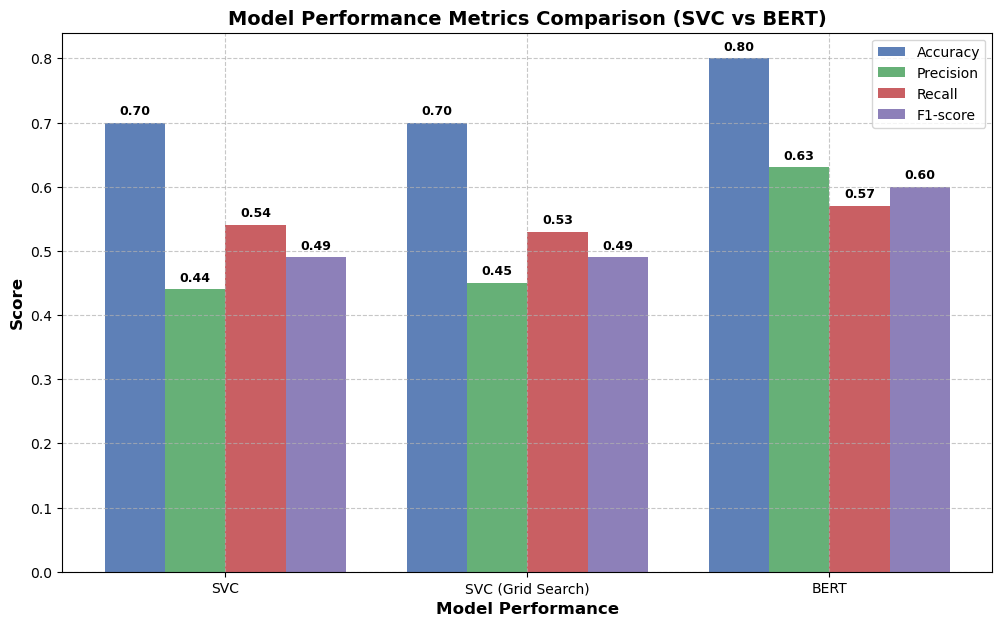

In [98]:
import matplotlib.pyplot as plt
import numpy as np

models = ["SVC", "SVC (Grid Search)", "BERT"]

accuracy = [0.70, 0.70, 0.80]
precision = [0.44, 0.45, 0.63]
recall = [0.54, 0.53, 0.57]
f1_score = [0.49, 0.49, 0.60]


x = np.arange(len(models))
width = 0.2
plt.figure(figsize=(12, 7))
bars1 = plt.bar(x - 1.5*width, accuracy, width, label='Accuracy', alpha=0.9, color='#4c72b0')
bars2 = plt.bar(x - 0.5*width, precision, width, label='Precision', alpha=0.9, color='#55a868')
bars3 = plt.bar(x + 0.5*width, recall, width, label='Recall', alpha=0.9, color='#c44e52')
bars4 = plt.bar(x + 1.5*width, f1_score, width, label='F1-score', alpha=0.9, color='#8172b2')


def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',xy=(bar.get_x() + bar.get_width() / 2, height),xytext=(0, 6), textcoords="offset points",
                     ha='center', fontsize=9, fontweight='bold', color='black')


add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)


plt.xlabel('Model Performance', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Model Performance Metrics Comparison (SVC vs BERT)', fontsize=14, fontweight='bold')
plt.xticks(x, models, fontsize=10)
plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.7)

plt.savefig("model_performance_metrics_with_labels.png")
plt.show()
